In [1]:
# https://stackoverflow.com/questions/49429585/how-to-change-the-background-color-of-a-single-cell-in-a-jupyter-notebook-jupy
from IPython.core.magic import register_line_magic
from IPython.display import HTML, display
import json

@register_line_magic
def bg(color, cell=None):    
    script = (
        "var n = [this.closest('.cell,.jp-CodeCell')];"
        "n = n.concat([].slice.call(n[0].querySelectorAll('.input_area,.highlight,.jp-Editor')));"
        f"n.forEach(e=>e.style.background='{color}');"
        "this.parentNode.removeChild(this)"
    )
    display(HTML(f'<img src onerror="{script}" style="display:none">'))  

# **Integrated CA**:  
## Twitter API Data Analysis

*Lecturers:* Muhammad Iqbal, David McQuaid

*Student:* [2020491]

## **Data Understanding:**

### **Data Collection:**
#### **Data Source:**
**`Twitter API`**<br>
The Twitter API enables programmatic access to Twitter elements such as: Tweets, Direct Messages, Spaces, Lists, users etc.<br>

https://developer.twitter.com/en/docs/twitter-api

<hr>

#### **Datasets:** 
**`ProjectTweets`**<br>
Created using Twitter API.

#### Import Modules
The required packages are imported for analysis.

In [2]:
 #!pip install plotly#==5.5.0

In [3]:
# Import Modules
try:
    import pandas as pd
    import matplotlib.pyplot as plt
    import seaborn as sns

    import numpy as np
    
    import statistics as st # Statistical Module(in Standard Library)
    import researchpy as rp
    
    import warnings
    warnings.filterwarnings("ignore")
except ModuleNotFoundError:
    !pip install seaborn numpy matplotlib researchpy plotly

#### Loading the Datasets
Takes a couple of seconds to load in the dataset. Huge improvement from the minutes it took before initial cleaning.

In [4]:
%%time
df = pd.read_csv("./Data/ProjectTweets.csv")#,encoding = 'utf-16-le',sep='\t')#latin'utf-16',on_bad_lines='skip')#,lineterminator='\n')#,encoding_errors='replace')#,error_bad_lines=False)#)encoding="windows-1252"
#df_iso = pd.read_excel("./Data/_ISO-3166.xlsx")#sheet_name=0, header=0, names=None, index_col=None, usecols=None)

CPU times: total: 2.73 s
Wall time: 2.75 s


#### **`Data Naming`**

In [5]:
# Assigning row names to data without headers
cols = ["ids","date","flag","user","text"]
df = pd.read_csv('./Data/ProjectTweets.csv', header=None, names=cols)#, index_col="ids")
len(df)

1600000

### **Data Description:**
To analyse the data, I conducted initial analysis on the dataset that can be seen step-by-step below. 

In [6]:
df['text'].describe()

count                       1600000
unique                      1581466
top       isPlayer Has Died! Sorry 
freq                            210
Name: text, dtype: object

#### Data Size & Dimensions: 
The data size of **1600000** entry meets the requirements of accurate model creation.

In [7]:
# Dimensions
print("Row:{} x Columns:{}".format(df.shape[0],df.shape[1]))

Row:1600000 x Columns:5


#### Data Overview
The `head` and `tail` functions show the first and last N observations in the data set which gives a glimpse at the structure of the data.

In [8]:
N = 5
display(df.head(N))
display(df.tail(N))

,ids,date,flag,user,text
0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


,ids,date,flag,user,text
1599995,2193601966,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,AmandaMarie1028,Just woke up. Having no school is the best fee...
1599996,2193601969,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,TheWDBoards,TheWDB.com - Very cool to hear old Walt interv...
1599997,2193601991,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,bpbabe,Are you ready for your MoJo Makeover? Ask me f...
1599998,2193602064,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,tinydiamondz,Happy 38th Birthday to my boo of alll time!!! ...
1599999,2193602129,Tue Jun 16 08:40:50 PDT 2009,NO_QUERY,RyanTrevMorris,happy #charitytuesday @theNSPCC @SparksCharity...


The `info` function depicts data about each variable in the data set as well as the dataset as a whole.
There are 3 columns and 1600000 rows. There are no missing values in the entire data.

In [9]:
# verbose:full_summary   null_counts:show_NaN   memory_usage:Exact_Size  
df.info(verbose=True, null_counts=True,memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1600000 entries, 0 to 1599999
Data columns (total 5 columns):
 #   Column  Non-Null Count    Dtype 
---  ------  --------------    ----- 
 0   ids     1600000 non-null  int64 
 1   date    1600000 non-null  object
 2   flag    1600000 non-null  object
 3   user    1600000 non-null  object
 4   text    1600000 non-null  object
dtypes: int64(1), object(4)
memory usage: 556.1 MB


# Data Preprocessing

### **Preprocessing**

Error arises when trying to make **ids** the id of the dataframe.
So verification of possible duplication is required!
#### IDs Duplication?

In [10]:
# There are 1685 non-uniquely identified texts!!
print(len(df.ids)-len(df.ids.unique()))

1685


In [11]:
df[df.duplicated(subset='ids', keep=False)].sort_values(by='ids', ascending=True)

,ids,date,flag,user,text
213,1467863684,Mon Apr 06 22:33:35 PDT 2009,NO_QUERY,DjGundam,Awwh babs... you look so sad underneith that s...
800261,1467863684,Mon Apr 06 22:33:35 PDT 2009,NO_QUERY,DjGundam,Awwh babs... you look so sad underneith that s...
275,1467880442,Mon Apr 06 22:38:04 PDT 2009,NO_QUERY,iCalvin,Haven't tweeted nearly all day Posted my webs...
800300,1467880442,Mon Apr 06 22:38:04 PDT 2009,NO_QUERY,iCalvin,Haven't tweeted nearly all day Posted my webs...
989,1468053611,Mon Apr 06 23:28:09 PDT 2009,NO_QUERY,mariejamora,@hellobebe I also send some updates in plurk b...
...,...,...,...,...,...
524290,2193428118,Tue Jun 16 08:26:44 PDT 2009,NO_QUERY,bubbles00,"finally finished typing!!!! Woohoooo , still ..."
1599440,2193451289,Tue Jun 16 08:28:37 PDT 2009,NO_QUERY,faiznurdavid,"@fanafatin see, @misschimichanga tweet u to jo..."
524345,2193451289,Tue Jun 16 08:28:37 PDT 2009,NO_QUERY,faiznurdavid,"@fanafatin see, @misschimichanga tweet u to jo..."
524688,2193576442,Tue Jun 16 08:38:45 PDT 2009,NO_QUERY,emma_b_xox,Had an injection today. Not fun the rrst of t...


It seems that the queries that have identical `ids` also have all their data duplicated. But still need to be verified.
#### Record Duplication?

In [12]:
grouped = df.groupby('ids')

In [13]:
# Identify duplicate rows with all columns the same
duplicate_rows = df[df.duplicated(keep=False)]

if duplicate_rows.empty:
    print("No duplicate rows with all columns the same!")
else:
    print("There are duplicate rows with all columns the same:")
    print(duplicate_rows)

There are duplicate rows with all columns the same:
                ids                          date      flag          user  \
213      1467863684  Mon Apr 06 22:33:35 PDT 2009  NO_QUERY      DjGundam   
275      1467880442  Mon Apr 06 22:38:04 PDT 2009  NO_QUERY       iCalvin   
989      1468053611  Mon Apr 06 23:28:09 PDT 2009  NO_QUERY   mariejamora   
1177     1468100580  Mon Apr 06 23:42:57 PDT 2009  NO_QUERY   cristygarza   
1254     1468115720  Mon Apr 06 23:48:00 PDT 2009  NO_QUERY    WarholGirl   
...             ...                           ...       ...           ...   
1598780  2193278017  Tue Jun 16 08:14:22 PDT 2009  NO_QUERY   janiecwales   
1599298  2193403830  Tue Jun 16 08:24:44 PDT 2009  NO_QUERY   lauren__x33   
1599385  2193428118  Tue Jun 16 08:26:44 PDT 2009  NO_QUERY     bubbles00   
1599440  2193451289  Tue Jun 16 08:28:37 PDT 2009  NO_QUERY  faiznurdavid   
1599931  2193576442  Tue Jun 16 08:38:45 PDT 2009  NO_QUERY    emma_b_xox   

                       

The records with the same ids are duplicate records so these data's are removed.

In [14]:
df.drop_duplicates(keep='last', inplace=True)
df.reset_index(drop=True, inplace=True)

#### Missing Data?

In [108]:
df.isnull().sum()

date            0
user            0
text            0
cleaned_text    0
dtype: int64

#### **Irrelevant Data**
As seen below, the only value the `flag` variable has is NO_QUERY hence it can be removed. 

In [15]:
df.flag.unique()

array(['NO_QUERY'], dtype=object)

In [16]:
df.drop('flag', axis=1, inplace=True)

The `ids` column is unnecessary for the analysis, since the best way to sort this data is with the date of the tweet and then indexing it accordingly without the need to store and handle large integer values (i.e. Big integers). 

Not to mention the different issues that may arise from big integers such as:
- **Memory Usage** which limits the capacity of the analysis
- **Performing arithmetic** operations slow down with increased bit size for calculations
- **Computation** Libraries/Functions might not be optimized for big integers, leading to slower computations or potential errors
- **Overflow** operations on big integers may cause overflow errors if arbitrary precision arithmetic not handled
- **Visualization** Big integers can cause issues with data visualization libraries, e.g. when generating charts & graphs. Also, Scaling Big integer axes might also lead to distorted visualizations.

For these reasons the `ids` column can be removed.

In [17]:
df.drop('ids', axis=1, inplace=True)

#### Text Formatting
Text needs to be converted from object to string format to be analysed.

In [71]:
# Converting 'text' column to string
df['text'] = df['text'].astype(str)  

#### Date Formatting

To be able to sort the data based on date, the date needs to be converted to `datetime format`. For this the  date string format needs to be processed.

In [18]:
# Get sample e.g. 3rd indexed date
df.iloc[2:3].date

2    Mon Apr 06 22:19:53 PDT 2009
Name: date, dtype: object

In [19]:
# Date Format
#date_format = "%a %b %d %H:%M:%S %Z %Y"

#df['date'].apply(lambda x: datetime.strptime(x, date_format))

The Format of the date is:
- %a: Weekday abbreviated (e.g. Mon)
- %b: Month abbreviated (e.g Apr)
- %d: Day of the month as a zero padded number (e.g. 06)
- %H: Hour (24-hour) as a zero padded number (e.g. 22)
- %M: Minute as a zero padded number (e.g. 19)
- %S: Second as a zero padded number (e.g. 53)
- %Z: Time zone (e.g. PDT)
- %Y: Year (e.g. 2009)

When trying to use `datetime` library ValueError occurs due to the *PDT* and *PST* time zone abbreviations,  not being directly supported by the strptime() function. To handle such time zone abbreviations, I use the pytz library along with dateutil for parsing the date string.

In [20]:
#!python.exe -m pip install --upgrade pip

In [21]:
!pip install pytz python-dateutil

In [22]:
#from datetime import datetime
import pytz
from dateutil import parser

In [23]:
df.head(n=3)

,date,user,text
0,Mon Apr 06 22:19:45 PDT 2009,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,Mon Apr 06 22:19:49 PDT 2009,scotthamilton,is upset that he can't update his Facebook by ...
2,Mon Apr 06 22:19:53 PDT 2009,mattycus,@Kenichan I dived many times for the ball. Man...


##### `Setting Timezone to UTC`
Using the *tz_convert* method to make sure the timezone is set to UTC to avoid timezone related issues (possibly in e.g. plotting)

In [24]:
# Takes a couple of minutes
df['date'] = df['date'].apply(lambda x: parser.parse(x).astimezone(pytz.utc))
df['date'] = df['date'].dt.tz_convert('UTC')

In [25]:
df['date']

0         2009-04-06 21:19:45+00:00
1         2009-04-06 21:19:49+00:00
2         2009-04-06 21:19:53+00:00
3         2009-04-06 21:19:57+00:00
4         2009-04-06 21:19:57+00:00
                     ...           
1598310   2009-06-16 07:40:49+00:00
1598311   2009-06-16 07:40:49+00:00
1598312   2009-06-16 07:40:49+00:00
1598313   2009-06-16 07:40:49+00:00
1598314   2009-06-16 07:40:50+00:00
Name: date, Length: 1598315, dtype: datetime64[ns, UTC]

#### Data Sorting with Date
Reindexing the data by sorting based on date from oldest to most recent tweet.

In [26]:
df.sort_values(by='date').reset_index(drop=True, inplace=True)

#### Store Processed Data
To save time with the analysis processed data is saved here to be used later.

In [27]:
df2 = df.copy()

### Possible Scam & Irrelevant Data
Any tweet has the probability to contain malicious link to check its validity would take extensive analysis not to mention how it is an irrelevant data for the analysis to be conducted. For the these reasons it is removed for further analysis.

In [28]:
import re

# Regular Expression Pattern (to find websites)
pattern = r'\b(?:https?://|www\.)\S+(?=\s|$)|\S+\.com\b'  # Match start: http,https,www. & end with'.com',before whitespace  

# Website Extraction from each row in the 'text' column
websites_list = df['text'].apply(lambda x: re.findall(pattern, x))

# List Flattening (removing null values & merge into one list)
websites = [website for sublist in websites_list for website in sublist]

print(websites)

['http://twitpic.com/2y1zl', 'http://is.gd/fNge', 'http://tinyurl.com/dcuc33', 'www.diigo.com/~tautao', 'http://twitpic.com/2y2es', 'http://apps.facebook.com/dogbook/profile/view/5248435', 'http://tr.im/imji', 'http://apps.facebook.com/dogbook/profile/view/6176014', 'http://ff.im/1XTTi', 'http://www.erika-obscura.blogspot.com', 'http://twitpic.com/2y2wr', 'http://tinyurl.com/cw2l9t', 'http://tinyurl.com/ceprvs', 'http://twitpic.com/2y2yi', 'https://www.mycomicshop.com/search?TID=395031', 'http://tinyurl.com/cec5ka', 'http://twitpic.com/2y34e', 'http://tinyurl.com/dc2htx', 'http://twitpic.com/2y36e', 'http://is.gd/r8Zf,', 'http://is.gd/r8Zy,', 'http://is.gd/r8ZG', 'http://tinyurl.com/c4ooho', 'godaddy.com', 'http://twitpic.com/2y3cf', 'http://tinyurl.com/c8bvqh', 'http://tinyurl.com/cxe8w7', 'http://fanclub.backstreetboys.com/chat.php', 'http://twitpic.com/2y1pe', 'http://twitpic.com/2y3jp', 'http://loopt.us/KoqAbg', 'http://twitpic.com/2y3ty', 'http://twitpic.com/2y3y0', 'http://plurk.

In [29]:
from collections import Counter
websites_counts = Counter(websites)

In [30]:
websites_counts.most_common()

[('www.tweeteradder.com', 830),
 ('http://tweet.sg', 751),
 ('www.tweeterfollow.com', 654),
 ('www.iamsoannoyed.com', 245),
 ('myspace.com', 153),
 ('http://www.4officeautomation.com', 100),
 ('http://tr.im/lvBu', 86),
 ('http://tinyurl.com/ry9wap', 86),
 ('http://twitpic.com/6q1om', 86),
 ('twitter.com', 80),
 ('www.m2e.asia', 79),
 ('http://twitpic.com/6shtr', 77),
 ('http://bit.ly/PmvRY', 68),
 ('http://ustre.am/2UhS)', 62),
 ('http://bit.ly/votetom', 62),
 ('http://ustre.am/39qb)', 60),
 ('http://bit.ly/VwV6H', 58),
 ('http://twitpic.com/7gowf', 52),
 ('http://fuzz-ball.com/twitter', 51),
 ('http://tinyurl.com/dhpol7', 47),
 ('http://bit.ly/1864ml', 45),
 ('psykoid.com', 45),
 ('http://tinyurl.com/c44c6r', 44),
 ('http://ustre.am/2f9i)', 43),
 ('http://ustre.am/2wLS)', 40),
 ('http://twitpic.com/6dvj4', 40),
 ('http://ustre.am/2txz)', 39),
 ('http://tr.im/jFd7', 38),
 ('youtube.com', 37),
 ('http://twitpic.com/6g55n', 37),
 ('[phplurk.com', 34),
 ('http://ustre.am/2YyQ)', 34),
 ('h

In [31]:
# Remove URLs from 'text' column's each row
df.text = df.text.apply(lambda x: re.sub(pattern, '', x))

In [32]:
# Checker
#[website for sublist in df['text'].apply(lambda x: re.findall(pattern, x)) for website in sublist]

In [33]:
df

,date,user,text
0,2009-04-06 21:19:45+00:00,_TheSpecialOne_,"@switchfoot - Awww, that's a bummer. You sho..."
1,2009-04-06 21:19:49+00:00,scotthamilton,is upset that he can't update his Facebook by ...
2,2009-04-06 21:19:53+00:00,mattycus,@Kenichan I dived many times for the ball. Man...
3,2009-04-06 21:19:57+00:00,ElleCTF,my whole body feels itchy and like its on fire
4,2009-04-06 21:19:57+00:00,Karoli,"@nationwideclass no, it's not behaving at all...."
...,...,...,...
1598310,2009-06-16 07:40:49+00:00,AmandaMarie1028,Just woke up. Having no school is the best fee...
1598311,2009-06-16 07:40:49+00:00,TheWDBoards,- Very cool to hear old Walt interviews! â«
1598312,2009-06-16 07:40:49+00:00,bpbabe,Are you ready for your MoJo Makeover? Ask me f...
1598313,2009-06-16 07:40:49+00:00,tinydiamondz,Happy 38th Birthday to my boo of alll time!!! ...


In [85]:
# Count occurrences of a word in the 'text' for each date (only showing with result)
df['text'][df['text'].apply(lambda x: x.lower().count('school') > 0)]

1          is upset that he can't update his Facebook by ...
66                              Damm back to school tomorrow
167        Going to school soon... can't find anything to...
299        Mraow, I feel like dancing, but first art scho...
321            walking home from school drains all my energy
                                 ...                        
1597902    @hadasaguilar loved does not preclude annoying...
1598072    Goodmorning tweethearts! Besides Covina High S...
1598198    got our yearbooks in school  gonna try and get...
1598216    Had an injection today. Not fun  the rrst of t...
1598280    Just woke up. Having no school is the best fee...
Name: text, Length: 20892, dtype: object

### Duplicate Texts
Duplicate texts over a period of time may arise for a number of reasons such as:
- After cleaning the text from URLs it is possible that some might have become empty (i.e. text only had link). These need to be removed as they contain no information about the sentiment of the tweets. They are useful for initial analysis to check the users presence frequency.
- Users might follow a trend or have a strong emotion to certain topics, these can be left in to emphasis their sentimental impact on the community

In [34]:
df[df.duplicated(subset='text', keep=False)].sort_values(by='text', ascending=True)

,date,user,text
1377553,2009-06-05 22:40:50+00:00,faultlines,
1543110,2009-06-15 11:24:59+00:00,Ohkissme,
297863,2009-06-01 16:29:38+00:00,officialcoria,
502717,2009-06-15 20:17:59+00:00,Helen_xo,
871435,2009-05-02 07:58:33+00:00,KrisJacksonnerd,
...,...,...,...
255767,2009-05-31 14:45:25+00:00,xxdesireexx,yuckkk its pouring rain &amp; im filthy now!! ...
455661,2009-06-07 18:28:47+00:00,dawnstokes2,"zofran is not making this work day any easier,..."
456699,2009-06-07 18:57:37+00:00,nancymack4,"zofran is not making this work day any easier,..."
463316,2009-06-14 23:21:43+00:00,Yukkaogebb,~ get SUICIDE !!


In [35]:
# Removing leading & trailing whitespaces from 'text' (to show it as empty)
df.text = df.text.str.strip()

# Removing rows with empty 'text'
df = df[df['text'].notna() & (df['text'] != '')]

df.reset_index(drop=True, inplace=True)

In [36]:
df[df.duplicated(subset='text', keep=False)].sort_values(by='text', ascending=True)

,date,user,text
1095400,2009-05-30 02:35:18+00:00,fckrrcom,#3hotwords all right here NSFW &gt;&gt;
1147855,2009-05-30 22:05:49+00:00,fckrrcom,#3hotwords all right here NSFW &gt;&gt;
1258192,2009-06-01 17:10:22+00:00,fckrrcom,#3hotwords all right here NSFW &gt;&gt;
1031009,2009-05-26 22:19:52+00:00,fckrrcom,#3hotwords all right here NSFW &gt;&gt;
152466,2009-05-26 21:22:43+00:00,HSWarriorAaron,#3wordsaftersex sry i fell asleep
...,...,...,...
194375,2009-05-30 02:44:28+00:00,marniexo,yuckkk its pouring rain &amp; im filthy now!! ...
456695,2009-06-07 18:57:37+00:00,nancymack4,"zofran is not making this work day any easier,..."
455657,2009-06-07 18:28:47+00:00,dawnstokes2,"zofran is not making this work day any easier,..."
462432,2009-06-14 22:52:55+00:00,Yukkaogebb,~ get SUICIDE !!


### HTML Character Entities
Having Entity names could affect the analysis for a number of reasons including:
- *Interpretation error* e.g. sentiment analysis may have the meaning of the text distorted
- *Tokenization Disruption* with possible incorrect word counts
- *ML* introducing additional features not contributing to text meaning could impact the *model*'s performance & generalization
- *Data Cleaning* HTML entities can be considered noise during text analysis
- ...

To avoid it these are removed from the text.

In [37]:
# Replace HTML entities in the 'text' column
df['text'] = df['text'].str.replace('&gt;', '>', regex=True)
df['text'] = df['text'].str.replace('&lt;', '<', regex=True)
df['text'] = df['text'].str.replace('&amp;', '&', regex=True)

In [38]:
!pip install beautifulsoup4

In [39]:
from bs4 import BeautifulSoup

In [40]:
# Remove HTML entities in the 'text' column
df['text'] = df['text'].apply(lambda x: BeautifulSoup(x, 'html.parser').get_text())

### Possible Inappropriate Texts
Throughout the preprocessing phase of the analysis I have found possible culprits of inappropriate texting behavior. Although this would need further analysis later on since talking about this topic does not necesarily imply bad faith but filtering this out is time consumming. Furthermore, it could shed light to a possible regular cyber attacks by certain menacing individuals. Additionally, even if an uncomfortable topic it can still hold sentimental value so might be left in for the analysis.

In [41]:
pattern = r'\bNSFW\b|\bsex\b'

df[df['text'].str.contains(pattern, case=False, regex=True)]

,date,user,text
636,2009-04-06 22:03:34+00:00,LFTA,listening to Murd and 9th wonder- just chillen...
5139,2009-04-07 03:48:29+00:00,aznmnx,I hate no sex week
10891,2009-04-18 07:11:14+00:00,GavinTate,@rbflygal what's a bridal shower without sex t...
11548,2009-04-18 08:00:47+00:00,KristenYanda,@latticelinux Grr...you need sex every hour on...
15384,2009-04-18 15:09:34+00:00,jenniohio,time to work on my sex paper
...,...,...,...
1588047,2009-06-16 03:57:44+00:00,ChaseTheChad,Who's offering ya girl some bday sex
1590269,2009-06-16 04:44:13+00:00,chrstphrbrwn,@gtvone Oopsie! I got drunk and post your ha...
1593066,2009-06-16 05:42:49+00:00,JeJa6,"@SashaBaby22 invent sex. Ps, Sangria is most d..."
1595159,2009-06-16 06:33:16+00:00,MariaVonLiz,Walked that damn hill up kingsbridge now I'm s...


In [42]:
df.loc[1095400, 'text']

'#3hotwords all right here  NSFW >>'

# TEXT ANALYSIS

### Dataset's Timespan
Calculating the span by subtracting the earliest from the latest date.
Below, it shows the dataset contains 79 days, 12 hours, 8 minutes and 46 seconds of tweets.

In [86]:
# Timespan of the Dataset
df['date'].max() - df['date'].min()

Timedelta('79 days 12:08:46')

### Hashtags
Checking the keywords used by users.

In [43]:
import re

pattern = r'#(\w+)'
hashtags_list = [mention for sublist in df['text'].apply(lambda x: re.findall(pattern, x)) for mention in sublist]
#mentions = [mention for sublist in mentions_list for mention in sublist]

In [44]:
from collections import Counter
hashtags_counts = Counter(hashtags_list)

In [45]:
#sorted(hashtags_counts)

# Descending Order
hashtags_counts.most_common()

# Ascending Order
#sorted(hashtags_counts.items(), key=lambda x: x[1])

[('followfriday', 2112),
 ('fb', 1744),
 ('squarespace', 887),
 ('FF', 586),
 ('1', 518),
 ('seb', 499),
 ('FollowFriday', 463),
 ('musicmonday', 404),
 ('ff', 399),
 ('iranelection', 359),
 ('2', 341),
 ('fail', 301),
 ('BSB', 299),
 ('myweakness', 269),
 ('iremember', 268),
 ('asot400', 264),
 ('marsiscoming', 248),
 ('mcflyforgermany', 230),
 ('andyhurleyday', 188),
 ('iPhone', 185),
 ('inaperfectworld', 183),
 ('f1', 168),
 ('haveyouever', 168),
 ('delongeday', 167),
 ('spymaster', 160),
 ('trackle', 159),
 ('tcot', 155),
 ('mileymonday', 155),
 ('bgt', 153),
 ('e3', 133),
 ('iphone', 130),
 ('shaunjumpnow', 127),
 ('3', 126),
 ('E3', 124),
 ('IranElection', 118),
 ('goodsex', 114),
 ('bradiewebb', 106),
 ('hhrs', 105),
 ('clothdiapers', 105),
 ('dontyouhate', 103),
 ('mmwanted', 98),
 ('140conf', 96),
 ('flylady', 95),
 ('andyclemmensen', 95),
 ('asylm', 95),
 ('tag', 93),
 ('shaundiviney', 93),
 ('BGT', 92),
 ('F1', 90),
 ('chesterday', 90),
 ('hoppusday', 89),
 ('eu09', 85),
 ('

#### `Wordcloud`

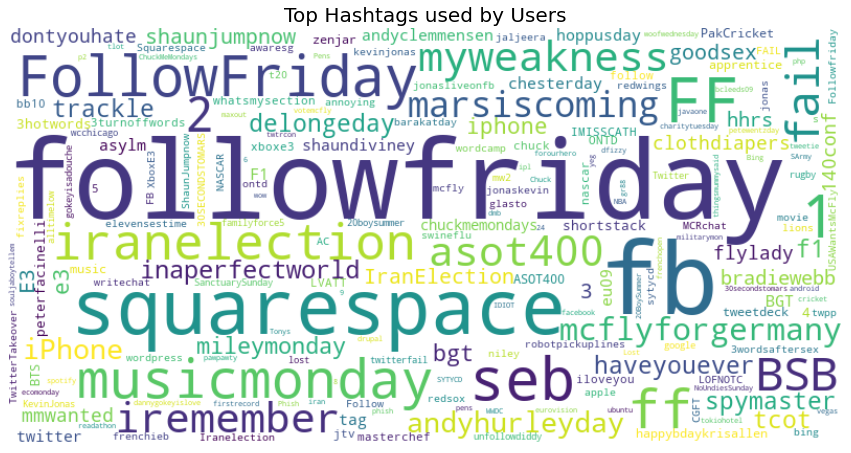

In [46]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# WordCloud object Creation
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(hashtags_counts)

# Plot Creation
plt.figure(figsize=(15, 10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Top Hashtags used by Users', size=20)

# Plot Showing
plt.show()

### Popular Users
Checking the users popularly tweeted by users.

In [47]:
import re

pattern = r'@(\w+)'
user_list = [mention for sublist in df['text'].apply(lambda x: re.findall(pattern, x)) for mention in sublist]

In [48]:
from collections import Counter
user_counts = Counter(user_list)

In [49]:
#sorted(user_counts)

# Descending Order
user_counts.most_common()

# Ascending Order
#sorted(user_counts.items(), key=lambda x: x[1])

[('mileycyrus', 4482),
 ('tommcfly', 3873),
 ('ddlovato', 3462),
 ('DavidArchie', 1295),
 ('Jonasbrothers', 1285),
 ('jordanknight', 1130),
 ('DonnieWahlberg', 1104),
 ('mitchelmusso', 1074),
 ('JonathanRKnight', 1071),
 ('taylorswift13', 1011),
 ('jonasbrothers', 984),
 ('selenagomez', 801),
 ('dougiemcfly', 789),
 ('peterfacinelli', 636),
 ('aplusk', 624),
 ('joeymcintyre', 578),
 ('Dannymcfly', 544),
 ('gfalcone601', 538),
 ('shaundiviney', 510),
 ('YoungQ', 507),
 ('kirstiealley', 434),
 ('TomFelton', 428),
 ('stephenfry', 420),
 ('iamdiddy', 397),
 ('officialTila', 390),
 ('lilyroseallen', 387),
 ('ashleytisdale', 385),
 ('johncmayer', 381),
 ('AlexAllTimeLow', 374),
 ('dannywood', 368),
 ('PerezHilton', 364),
 ('souljaboytellem', 346),
 ('Pink', 346),
 ('andyclemmensen', 342),
 ('dannygokey', 341),
 ('markhoppus', 338),
 ('petewentz', 332),
 ('TheRealJordin', 329),
 ('KimKardashian', 327),
 ('Wossy', 322),
 ('trent_reznor', 313),
 ('Alyssa_Milano', 313),
 ('yelyahwilliams', 312),

#### `Wordcloud`

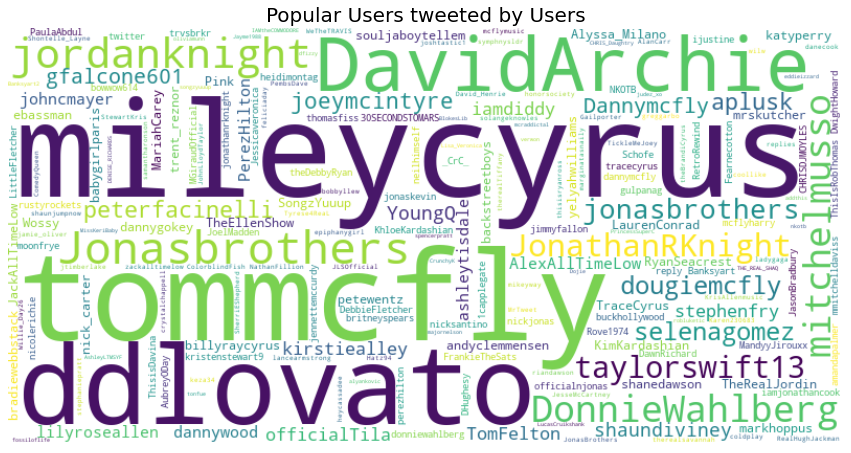

In [50]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# WordCloud object Creation
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(user_counts)

# Plot Creation
plt.figure(figsize=(15, 10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Popular Users tweeted by Users', size=20)

# Plot Showing
plt.show()

### 20 Top Tweeters

In [87]:
# 20 Top Tweeters
df['user'].value_counts().head(20)

lost_dog           549
webwoke            345
tweetpet           310
SallytheShizzle    281
VioletsCRUK        279
mcraddictal        276
tsarnick           248
what_bugs_u        246
Karen230683        238
DarkPiano          236
SongoftheOss       227
Jayme1988          225
keza34             219
ramdomthoughts     216
shanajaca          213
wowlew             212
TraceyHewins       211
nuttychris         211
thisgoeshere       207
Spidersamm         205
Name: user, dtype: int64

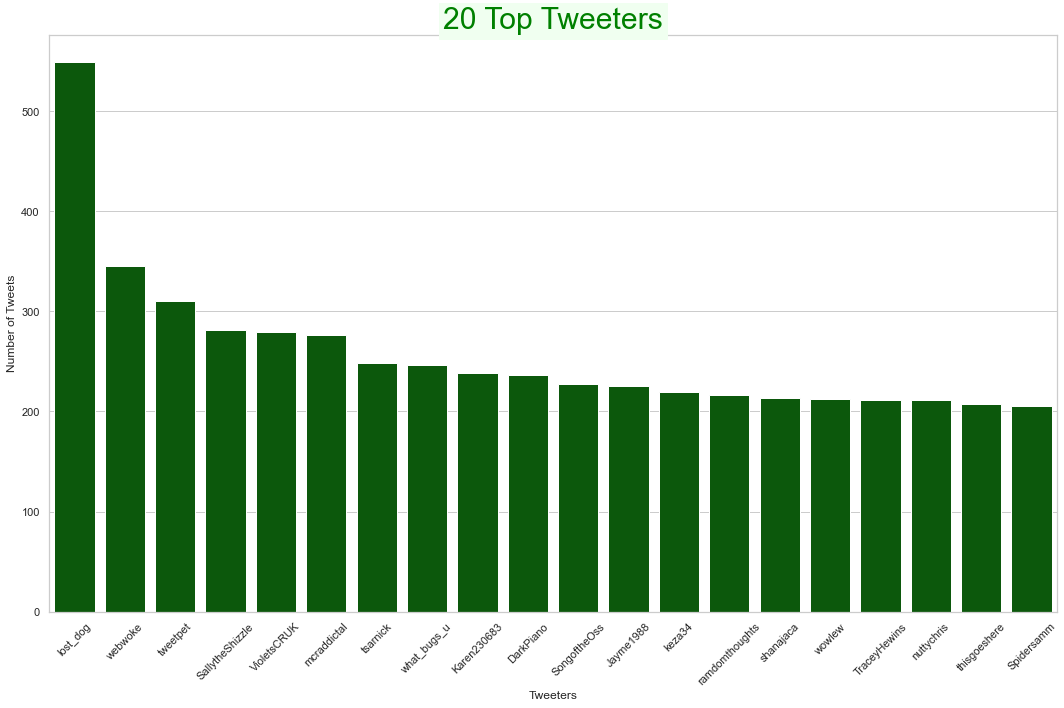

In [91]:
# 20 Top Tweeters over the span of dataset
tweeters = df['user'].value_counts().head(20)

# Seaborn Style
sns.set(style="whitegrid")

# Bar plot using Seaborn
plt.figure(figsize=(15, 10))
ax = sns.barplot(x=tweeters.index, y=tweeters.values, color='darkgreen')
plt.title('20 Top Tweeters',fontsize=30, color='green', backgroundcolor='honeydew')
plt.xlabel('Tweeters')
plt.ylabel('Number of Tweets')

ax.set_xticklabels([item for item in tweeters.index], rotation=45)

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### 20 Least Tweeters

In [89]:
# 20 Least Tweeters
df['user'].value_counts().tail(20)

alee_lee           1
too_gangsta        1
kaitlynmat         1
Kanappakick        1
lifesabliss10      1
Ghanthegr8         1
cherieseigneuri    1
DeeBlock432        1
funnykait7878      1
oOBLazerOo         1
fatema504          1
Night_shift_Doc    1
jasmin023          1
MoneyGuyBK         1
Pawitforwardllc    1
ayawan             1
nicolaboomsma      1
LynzRidonkulus     1
imkarenb           1
bpbabe             1
Name: user, dtype: int64

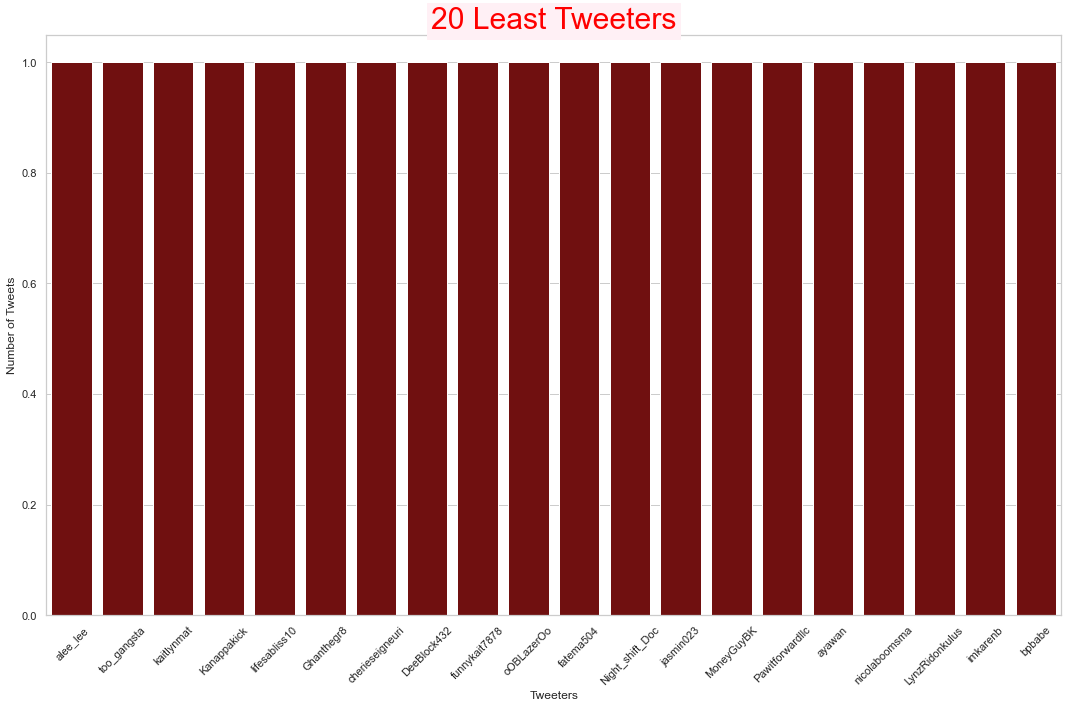

In [94]:
# 20 Least Tweeters over the span of dataset
tweeters = df['user'].value_counts().tail(20)

# Seaborn Style
sns.set(style="whitegrid")

# Bar plot using Seaborn
plt.figure(figsize=(15, 10))
ax = sns.barplot(x=tweeters.index, y=tweeters.values, color='maroon')
plt.title('20 Least Tweeters',fontsize=30, color='red', backgroundcolor='lavenderblush')
plt.xlabel('Tweeters')
plt.ylabel('Number of Tweets')

ax.set_xticklabels([item for item in tweeters.index], rotation=45)

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### Average Number of Tweets per Tweeter (over a span of 79 days)

In [95]:
# Average Number of Tweets per Tweeter (over a span of 79 days)
df['user'].value_counts().mean()

2.42250649852599

### Average Number of tweets per day (over a span of 79 days)

In [115]:
# Average number of tweets per day
df.groupby(df['date'].dt.date).size().mean()

33297.604166666664

### Total number of tweets per day

In [96]:
# Total number of tweets per day
df.groupby(df['date'].dt.date).size()

date
2009-04-06      5290
2009-04-07     15351
2009-04-17      3083
2009-04-18     23745
2009-04-19     27409
2009-04-20     18421
2009-04-21      6602
2009-05-01      9711
2009-05-02     27341
2009-05-03     35359
2009-05-04     13441
2009-05-09     13699
2009-05-10     24017
2009-05-11      4184
2009-05-13      6004
2009-05-14     15490
2009-05-16     11098
2009-05-17     42425
2009-05-18     32133
2009-05-21      6334
2009-05-22     34811
2009-05-23       169
2009-05-25       169
2009-05-26     10770
2009-05-27       839
2009-05-28     20097
2009-05-29     72918
2009-05-30    104314
2009-05-31     94591
2009-06-01    110205
2009-06-02     64147
2009-06-03     37138
2009-06-04      7835
2009-06-05     62805
2009-06-06    111646
2009-06-07     91996
2009-06-14     12900
2009-06-15    109485
2009-06-16     65337
2009-06-17     43809
2009-06-18     43041
2009-06-19     42933
2009-06-20     45390
2009-06-21     14800
2009-06-22     12009
2009-06-23     17001
2009-06-24      8151
2009-06-

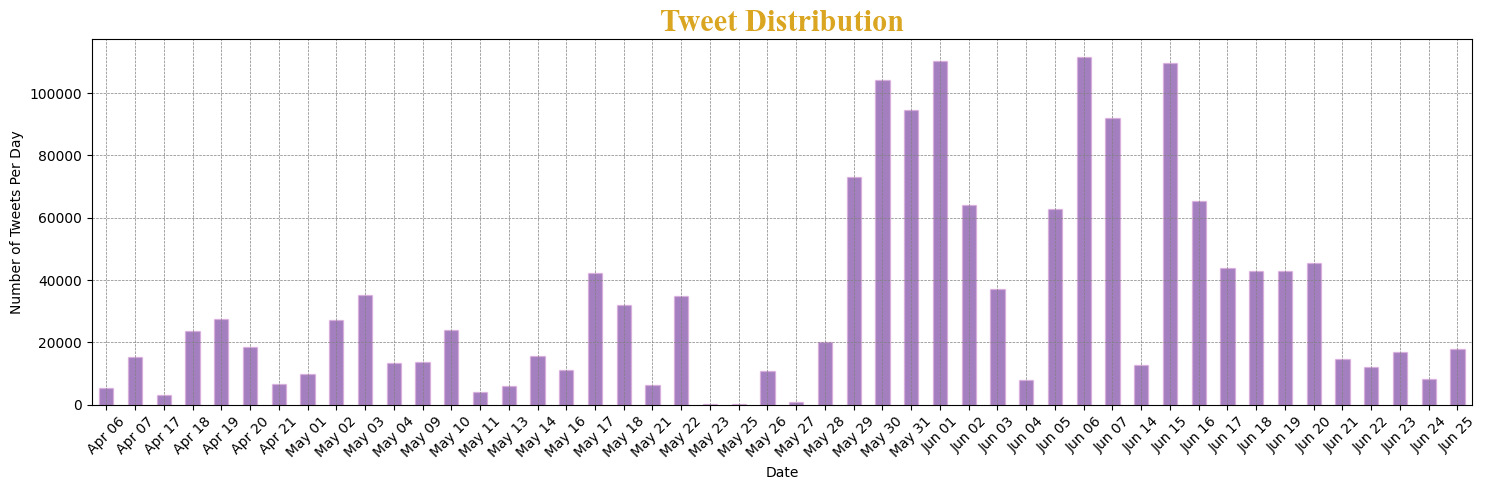

In [143]:
# DATEFORMATTER NOT WORKING --> from matplotlib.dates import DateFormatter
# USING APPLY FUNCTION

# Plot the number of tweets per day
plt.figure(figsize=(15, 5))

ax = df.groupby(df['date'].dt.date).size().plot(kind='bar',
                                                color='indigo',edgecolor='plum', alpha=0.5)
plt.title('Tweet Distribution',color= "goldenrod", fontsize=22,weight='bold',fontname="Times New Roman") 
plt.xlabel('Date')
plt.ylabel('Number of Tweets Per Day')

# Format tick labels to show only month and day
ax.set_xticklabels([item.strftime('%b %d') for item in df.groupby(df['date'].dt.date).size().index], rotation=45)

plt.grid(color='gray', linestyle='--', linewidth=0.5)

#date_form = DateFormatter("%d %b")
#ax.xaxis.set_major_formatter(date_form)

plt.xticks(rotation=45)
plt.tight_layout()

#plt.suptitle("Tweet Distribution", color= "gold", fontsize=22,weight='bold',fontname="Times New Roman")

plt.show()

### Regular Users only
If over the span of 79 days, a user hasn't at least tweeted 79 tweets then they are not considered regular i.e. equating to at least one tweet per day.
Below it shows that out of a total of **659765** users only **322** are regular users.

In [118]:
df.user.value_counts()[df['user'].value_counts() >= 79]

lost_dog           549
webwoke            345
tweetpet           310
SallytheShizzle    281
VioletsCRUK        279
                  ... 
YatPundit           79
caseysevenfold      79
WLxboxRox56         79
lisisilveira        79
letssingbaby        79
Name: user, Length: 322, dtype: int64

In [122]:
len(df.user.unique())

659765

### Users' Tweeting Pattern

In [129]:
print("Nunber of Tweets per day")
display(df.groupby(["user",df['date'].dt.month, df['date'].dt.day]).count())#.sort_values()#["Year"],ascending=True)
print("Tweets per day")
display(df.groupby(["user",df['date'].dt.month, df['date'].dt.day]).sum())#.sort_values()#["Year"],ascending=True)

Nunber of Tweets per day


date  text  cleaned_text
user            date date                          
000catnap000    4    20       1     1             1
                5    28       1     1             1
                     31       1     1             1
                6    6        2     2             2
                     20       1     1             1
...                         ...   ...           ...
zzzunzinnn      5    31       1     1             1
                6    6        1     1             1
                     7        1     1             1
zzzyourdreamzzz 6    2        1     1             1
zzzzeus111      6    23       1     1             1

[1272251 rows x 3 columns]

Tweets per day


text  \
user            date date                                                      
000catnap000    4    20    @Wumbologist huh uhu...i see dead people xD ab...   
                5    28    awake since six o'clock... i had two hours sle...   
                     31    this is one of the cartoons i used to watch to...   
                6    6     @Wumbologist hmmm...why notcan't get enough of it   
                     20    kinda miss my mom  shouldn't have called her t...   
...                                                                      ...   
zzzunzinnn      5    31    wat a mild SURPRISEEEEEEEEEE!!!!!!!! mah dear ...   
                6    6                        I LOVEEE.. YOU, M/\MMY! :Xxx..   
                     7     tanoshii tanoshiiiiiiiiiiiiiiii.. thak God, da...   
zzzyourdreamzzz 6    2     OMG...... Im the only 1 workin in clinic tonig...   
zzzzeus111      6    23    Wishing I were there.  Where?  Anywhere! Margh...   

                                                                cleaned_text  
user            date date                                                     
000catnap000    4    20    huh uhui see dead people xd abhalte kann ich d...  
                5    28    awake since six oclock i had two hours sleepan...  
                     31    this is one of the cartoons i used to watch to...  
                6    6                      hmmmwhy notcant get enough of it  
                     20     kinda miss my mom shouldnt have called her today  
...                                                                      ...  
zzzunzinnn      5    31    wat a mild surpriseeeeeeeeee mah dear bro cmin...  
                6    6                                 i loveee you mmmy xxx  
                     7     tanoshii tanoshiiiiiiiiiiiiiiii thak god dats ...  
zzzyourdreamzzz 6    2     omg im the only workin in clinic tonight and m...  
zzzzeus111      6    23    wishing i were there where anywhere margherita...  

[1272251 rows x 2 columns]

### Users' Overall Statistics

In [68]:
# User Statistics
df["user"].describe()

count      1598285
unique      659765
top       lost_dog
freq           549
Name: user, dtype: object

### Remove User names, Hashtags, Special Characters, Digits & Extra Spaces
To find the sentiment of the users hashtags and user names do not contribute to further analysis. So they are removed.

In [185]:
# Function to clean the text column
def clean_text(text):
    # Removing Words starting with '#' or '@'
    text = re.sub(r'[@#]\w+\s*', ' ', text)
    
    # Removing Special chars & Digits
    #text = re.sub(r'[^a-zA-Z\s]', '', text)
    # Removing Special chars & Digits except apostrophe (used for contraction handling!!!)
    text = re.sub(r'[^a-zA-Z\s\']', '', text)
    
    # Lowercase Conversion
    text = text.lower()
    
    # Removing Extra Space
    text = re.sub(r'\s+', ' ', text).strip()
    return text

In [186]:
df['cleaned_text'] = df['text'].apply(clean_text).astype(str)  

In [187]:
df

,date,user,text,cleaned_text,preprocessed_text
0,2009-04-06,_TheSpecialOne_,"@switchfoot - Awww, that's a bummer. You sho...",awww that's a bummer you shoulda got david car...,awww that 's bummer shoulda got david carr thi...
1,2009-04-06,scotthamilton,is upset that he can't update his Facebook by ...,is upset that he can't update his facebook by ...,upset cannot update facebook texting might cry...
2,2009-04-06,mattycus,@Kenichan I dived many times for the ball. Man...,i dived many times for the ball managed to sav...,dived many time 's ball managed save rest go b...
3,2009-04-06,ElleCTF,my whole body feels itchy and like its on fire,my whole body feels itchy and like its on fire,whole body feel 's itchy like fi are
4,2009-04-06,Karoli,"@nationwideclass no, it's not behaving at all....",no it's not behaving at all i'm mad why am i h...,no not behaving i am mad cannot see
...,...,...,...,...,...
1598280,2009-06-16,AmandaMarie1028,Just woke up. Having no school is the best fee...,just woke up having no school is the best feel...,woke no school best feeling ever
1598281,2009-06-16,TheWDBoards,- Very cool to hear old Walt interviews! â«,very cool to hear old walt interviews,cool hear old walt interview 's
1598282,2009-06-16,bpbabe,Are you ready for your MoJo Makeover? Ask me f...,are you ready for your mojo makeover ask me fo...,ready mojo makeover ask detail 's
1598283,2009-06-16,tinydiamondz,Happy 38th Birthday to my boo of alll time!!! ...,happy th birthday to my boo of alll time tupac...,happy th birthday boo alll time tupac amaru sh...


In [188]:
# BACKUP DATA!!!
df2 = df.copy()
#df = df2.copy()

#### `Check Empty texts` after preprocessing

In [189]:
# Removing leading & trailing whitespaces from 'text' (to show it as empty)
df.text = df.text.str.strip()

# Removing rows with empty 'text'
df = df[df['text'].notna() & (df['text'] != '')]

df.reset_index(drop=True, inplace=True)

In [190]:
# Check duplicates
df[df.duplicated(subset='text', keep=False)].sort_values(by='text', ascending=True)

,date,user,text,cleaned_text,preprocessed_text
1474519,2009-06-07,maryellla,""" BRAZIL SCREAMS IN ONE VOICE WE LOVE MILEY CY...",brazil screams in one voice we love miley cyrus,brazil scream 's one voice love miley cyru 's
1470530,2009-06-07,EdwardHF,""" BRAZIL SCREAMS IN ONE VOICE WE LOVE MILEY CY...",brazil screams in one voice we love miley cyrus,brazil scream 's one voice love miley cyru 's
192019,2009-05-30,Jeff_Hardyfan,"""@Jordanyup""have you the e-mail from Miley ?? ...",have you the email from miley i want to write ...,email miley want write cannot
192027,2009-05-30,Jeff_Hardyfan,"""@Jordanyup""have you the e-mail from Miley ?? ...",have you the email from miley i want to write ...,email miley want write cannot
192148,2009-05-30,Jeff_Hardyfan,"""@Jordanyup""have you the e-mail from Miley ?? ...",have you the email from miley i want to write ...,email miley want write cannot
...,...,...,...,...,...
255764,2009-05-31,xxdesireexx,yuckkk its pouring rain & im filthy now!! walk...,yuckkk its pouring rain im filthy now walking ...,yuckkk pouring rain i am filthy walking horrible
455657,2009-06-07,dawnstokes2,"zofran is not making this work day any easier,...",zofran is not making this work day any easier ...,zofran not making work day easier stomach les ...
456695,2009-06-07,nancymack4,"zofran is not making this work day any easier,...",zofran is not making this work day any easier ...,zofran not making work day easier stomach les ...
463312,2009-06-14,Yukkaogebb,~ get SUICIDE !!,get suicide,get suicide


### Change Date Format
For the analysis the time (hour,minute, second) the tweet was sent is irrelevant. Only the date is important hence the date is changed to only include the year, month and day of the tweet.

In [197]:
# Formating 'date' column to 'YYYY-MM-DD'
#df['date'] = df['date'].dt.strftime('%Y-%m-%d') # CREATES ERROR column not recognized as datetime obj
df['date'] = df['date'].apply(lambda x: x.strftime('%Y-%m-%d'))

In [198]:
df['date'] = pd.to_datetime(df['date'])

In [199]:
# BACKUP DATA!!!
#df2 = df.copy()
#df = df2.copy()

### Remove User Column
For the overall sentiment analysis it is irrelevant which user tweeted, the overall sentiment of the data is  crucial.

In [241]:
df.drop("user", axis=1, inplace=True)

# Text Processing
Before any text analysis can be performed text processing needs to be done. Below are the techiques used.

## Expanding Contractions

For the efficiency of the next step, i.e. removing stopwords, it is crucial to expand the contractions to the groups of words that they represent. e.g. didn't to did not... Athough it is important to note that in the text some of these are missing apostrophe signs in the text so it needs to be handled too.

In [206]:
!pip install contractions

In [205]:
#!pip install spacy
#!python -m spacy download en_core_web_sm

In [207]:
import re
import contractions
#import spacy

Using language model spaCy to tokenize the text and leverage its lemmatization feature to correctly handle contractions and missing apostrophes e.g. **thats** to **that is**.

In [183]:
# Loading spaCy language model
#nlp = spacy.load("en_core_web_sm")

In [221]:
# Function to expand contractions (including missing apostrophe)
def expand_contractions(text):
    # regex to add the missing apostrophes
    #text = re.sub(r"\b(\w+)(s|re)\b", r"\1 '\2", text)  
    return contractions.fix(text)

# Takes a couple minutes!!!!
# Apply contraction expansion function to the 'text' column
df['preprocessed_text'] = df['cleaned_text'].apply(expand_contractions)

KeyboardInterrupt: 

In [222]:
# BACKUP DATA!!!
#df2 = df.copy()
#df = df2.copy()

In [223]:
df

,date,user,text,cleaned_text,preprocessed_text
0,2009-04-06,_TheSpecialOne_,"@switchfoot - Awww, that's a bummer. You sho...",awww that's a bummer you shoulda got david car...,awww that is a bummer you shoulda got david ca...
1,2009-04-06,scotthamilton,is upset that he can't update his Facebook by ...,is upset that he can't update his facebook by ...,is upset that he cannot update his facebook by...
2,2009-04-06,mattycus,@Kenichan I dived many times for the ball. Man...,i dived many times for the ball managed to sav...,i dived many times for the ball managed to sav...
3,2009-04-06,ElleCTF,my whole body feels itchy and like its on fire,my whole body feels itchy and like its on fire,my whole body feels itchy and like its on fire
4,2009-04-06,Karoli,"@nationwideclass no, it's not behaving at all....",no it's not behaving at all i'm mad why am i h...,no it is not behaving at all i am mad why am i...
...,...,...,...,...,...
1598280,2009-06-16,AmandaMarie1028,Just woke up. Having no school is the best fee...,just woke up having no school is the best feel...,just woke up having no school is the best feel...
1598281,2009-06-16,TheWDBoards,- Very cool to hear old Walt interviews! â«,very cool to hear old walt interviews,very cool to hear old walt interviews
1598282,2009-06-16,bpbabe,Are you ready for your MoJo Makeover? Ask me f...,are you ready for your mojo makeover ask me fo...,are you ready for your mojo makeover ask me fo...
1598283,2009-06-16,tinydiamondz,Happy 38th Birthday to my boo of alll time!!! ...,happy th birthday to my boo of alll time tupac...,happy th birthday to my boo of alll time tupac...


## Removing Stopwords
Stopwords (e.g. the, and, is, of, in etc.) being commonly used words that generally don't carry meaning. I will remove them for a number of reasons:

- reduce `noise` (in text analysis)
- improve `efficiency` reducing word size to process speeding up algorithms and save memory
- better `interpretation` for topic modeling more meaningful and interpretable topics
    

It is important to consider how sometimes stopwords might be crucial for instance: in sentiment analysis some stopwords like **not** can change the meaning. In such cases, retaining certain stopwords.

Hence, I will retain stopwords 'no' and 'not' to presence the meaning.

In [224]:
from nltk.corpus import stopwords

# Defining stopwords with exceptions
stop_words = set(stopwords.words('english')) - {'no', 'not'}

def stopwords_removal_with_exception(text, exceptions):
    words = word_tokenize(text)
    filtered_words = [word for word in words if word not in stop_words or word in exceptions]
    return ' '.join(filtered_words)

In [225]:
df['preprocessed_text'] = df['preprocessed_text'].apply(lambda x: stopwords_removal_with_exception(x, {'no', 'not'}))

In [226]:
df

,date,user,text,cleaned_text,preprocessed_text
0,2009-04-06,_TheSpecialOne_,"@switchfoot - Awww, that's a bummer. You sho...",awww that's a bummer you shoulda got david car...,awww bummer shoulda got david carr third day
1,2009-04-06,scotthamilton,is upset that he can't update his Facebook by ...,is upset that he can't update his facebook by ...,upset not update facebook texting might cry re...
2,2009-04-06,mattycus,@Kenichan I dived many times for the ball. Man...,i dived many times for the ball managed to sav...,dived many times ball managed save rest go bounds
3,2009-04-06,ElleCTF,my whole body feels itchy and like its on fire,my whole body feels itchy and like its on fire,whole body feels itchy like fire
4,2009-04-06,Karoli,"@nationwideclass no, it's not behaving at all....",no it's not behaving at all i'm mad why am i h...,no not behaving mad not see
...,...,...,...,...,...
1598280,2009-06-16,AmandaMarie1028,Just woke up. Having no school is the best fee...,just woke up having no school is the best feel...,woke no school best feeling ever
1598281,2009-06-16,TheWDBoards,- Very cool to hear old Walt interviews! â«,very cool to hear old walt interviews,cool hear old walt interviews
1598282,2009-06-16,bpbabe,Are you ready for your MoJo Makeover? Ask me f...,are you ready for your mojo makeover ask me fo...,ready mojo makeover ask details
1598283,2009-06-16,tinydiamondz,Happy 38th Birthday to my boo of alll time!!! ...,happy th birthday to my boo of alll time tupac...,happy th birthday boo alll time tupac amaru sh...


## Text Tokenization & Stemming/Lemmatization
Using Porter stemming algorithm, to Stem the text has resulted in incorrect stemming such as his became hi, body became bodi. For this reason I decided to use lemmatization increase the chances to produce a valid base form (i.e. lemma) of the words.

In [228]:
import re

from nltk.stem import WordNetLemmatizer
#from nltk.stem import PorterStemmer

from nltk.tokenize import word_tokenize

In [229]:
def tokenize_and_lemmatize(text):
    # Tokenize the text
    words = word_tokenize(text)
    
    # Initialize stemmer
    #stemmer = PorterStemmer()
    # Stem words
    #stemmed_words = [stemmer.stem(word) for word in words] 
    #return ' '.join(stemmed_words)
    
    # Initialize lemmatizer
    lemmatizer = WordNetLemmatizer()    
    # Lemmatize words
    lemmatized_words = [lemmatizer.lemmatize(word) for word in words]    
    return ' '.join(lemmatized_words)   

In [230]:
# Takes a couple minutes!!!!
df['preprocessed_text'] = df['preprocessed_text'].apply(tokenize_and_lemmatize)

In [234]:
# BACKUP DATA!!!
df2 = df.copy()
#df = df2.copy()

In [148]:
%bg yellow
"*TO CONTINUE!!!*"

'*TO CONTINUE!!!*'

# Sentiment Labeling
Assigning sentiment labels to the text: positive, negative or neutral based on the sentiment expressed in the text. 

I will use the **VADER** sentiment analysis tool from the NLTK library, which is a pre-trained sentiment analysis models trained on large text datasets.



In [237]:
#!pip install nltk

In [239]:
import nltk
nltk.download('vader_lexicon') # used by SentimentIntensityAnalyzer

from nltk.sentiment.vader import SentimentIntensityAnalyzer

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\Foltos\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [240]:
# SentimentIntensityAnalyzer Initialisation
sia = SentimentIntensityAnalyzer()

# Assigning Sentiment Labels
def sentiment_label(text):
    
    sentiment_scores = sia.polarity_scores(text)
    compound_score = sentiment_scores['compound']
    
    if compound_score >= 0.05:
        return 'positive'
    
    elif compound_score <= -0.05:
        return 'negative'
    
    else:
        return 'neutral'

# Apply sentiment labeling function to the 'text' column
df['sentiment'] = df['preprocessed_text'].apply(sentiment_label)

              date             user  \
0       2009-04-06  _TheSpecialOne_   
1       2009-04-06    scotthamilton   
2       2009-04-06         mattycus   
3       2009-04-06          ElleCTF   
4       2009-04-06           Karoli   
...            ...              ...   
1598280 2009-06-16  AmandaMarie1028   
1598281 2009-06-16      TheWDBoards   
1598282 2009-06-16           bpbabe   
1598283 2009-06-16     tinydiamondz   
1598284 2009-06-16   RyanTrevMorris   

                                                      text  \
0        @switchfoot  - Awww, that's a bummer.  You sho...   
1        is upset that he can't update his Facebook by ...   
2        @Kenichan I dived many times for the ball. Man...   
3           my whole body feels itchy and like its on fire   
4        @nationwideclass no, it's not behaving at all....   
...                                                    ...   
1598280  Just woke up. Having no school is the best fee...   
1598281      - Very cool to hear ol

In [242]:
df

,date,text,cleaned_text,preprocessed_text,sentiment
0,2009-04-06,"@switchfoot - Awww, that's a bummer. You sho...",awww that's a bummer you shoulda got david car...,awww bummer shoulda got david carr third day,negative
1,2009-04-06,is upset that he can't update his Facebook by ...,is upset that he can't update his facebook by ...,upset not update facebook texting might cry re...,negative
2,2009-04-06,@Kenichan I dived many times for the ball. Man...,i dived many times for the ball managed to sav...,dived many time ball managed save rest go bound,positive
3,2009-04-06,my whole body feels itchy and like its on fire,my whole body feels itchy and like its on fire,whole body feel itchy like fire,negative
4,2009-04-06,"@nationwideclass no, it's not behaving at all....",no it's not behaving at all i'm mad why am i h...,no not behaving mad not see,positive
...,...,...,...,...,...
1598280,2009-06-16,Just woke up. Having no school is the best fee...,just woke up having no school is the best feel...,woke no school best feeling ever,positive
1598281,2009-06-16,- Very cool to hear old Walt interviews! â«,very cool to hear old walt interviews,cool hear old walt interview,positive
1598282,2009-06-16,Are you ready for your MoJo Makeover? Ask me f...,are you ready for your mojo makeover ask me fo...,ready mojo makeover ask detail,positive
1598283,2009-06-16,Happy 38th Birthday to my boo of alll time!!! ...,happy th birthday to my boo of alll time tupac...,happy th birthday boo alll time tupac amaru sh...,positive


In [243]:
df2 = df.copy()

# Model Training